In [2]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Get Interaction data

In [4]:
def get_data(directory,cov_name):
    files=[x for x in os.listdir(directory) if ".glm.linear" in x]
    compiled=pd.DataFrame()
    for x in files:
        df=pd.read_csv(directory+"/"+x,delimiter="\t")
        df=df[df["TEST"].str.contains(cov_name)]
        df["pheno"]=x.split("_")[0]
        df["P"]=pd.to_numeric(df["P"])
        compiled=compiled.append(df)
    compiled["assoc"]=compiled["ID"]+"_"+compiled["pheno"]
    return(compiled)
    

In [5]:
age_interact=get_data("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/interaction/ase/age/","ADDxage")
sex_interact=get_data("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/interaction/ase/sex/","ADDxSEX")

## get association file

In [6]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",delimiter="\t")
snps["assoc"]=snps["snp"]+"_"+snps["file"]
snps=snps[snps["assoc"].isin(age_interact["assoc"].tolist())]
snps=snps[~snps["assoc"].duplicated()]
snps=snps.rename(columns={"snp":"snps"})

In [7]:
age_interact_filt=age_interact[["pheno","ID","P"]]
age_interact_filt.columns=["file","snps","ADDxage"]
sex_interact_filt=sex_interact[["pheno","ID","P"]]
sex_interact_filt.columns=["file","snps","ADDxSEX"]

In [8]:
snps=pd.merge(snps,age_interact_filt,on=["file","snps"],how="left")
snps=pd.merge(snps,sex_interact_filt,on=["file","snps"],how="left")

## Age/Sex interaction

In [9]:
def fdr(df,P):
    probabilities = df[P].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    
    return(discoveries)

In [10]:
snps["fdr age"]=fdr(snps,"ADDxage")
snps["fdr sex"]=fdr(snps,"ADDxSEX")

In [11]:
len(snps[snps["fdr age"]<.1])

0

In [12]:
len(snps[snps["fdr sex"]<.1])

0

## Cell interaction

In [13]:
def get_data(directory,cov_name):
    files=[x for x in os.listdir(directory) if ".glm.linear" in x]
    compiled=pd.DataFrame()
    for x in files:
        df=pd.read_csv(directory+"/"+x,delimiter="\t")
        df=df[df["TEST"].str.contains(cov_name)]
        df["pheno"]=x.split("_")[0]
        df["P"]=pd.to_numeric(df["P"])
        compiled=compiled.append(df)
    return(compiled)
    

In [14]:
cell_interact=get_data("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/interaction/ase/cell-type","ADDx")

In [15]:
cell_interact["assoc"]=cell_interact["ID"]+"_"+cell_interact["pheno"]

In [16]:
df_cell_interact=cell_interact.pivot_table(index="assoc",columns="TEST",values="P")

In [17]:
df_cell_interact=df_cell_interact.reset_index()

In [18]:
print(len(df_cell_interact["assoc"].unique()))
df_cell_interact.head()

840


TEST,assoc,ADDxAdipocytes,ADDxAstrocytes,ADDxB.cells,ADDxBasophils,ADDxCD4..T.cells,ADDxCD4..Tcm,ADDxCD4..Tem,ADDxCD4..memory.T.cells,ADDxCD4..naive.T.cells,...,ADDxTh2.cells,ADDxTregs,ADDxaDC,ADDxcDC,ADDxiDC,ADDxly.Endothelial.cells,ADDxmv.Endothelial.cells,ADDxnaive.B.cells,ADDxpDC,ADDxpro.B.cells
0,6:26364628:A:C_HLA.A,0.650531,0.499171,0.728325,0.408635,0.217388,0.744204,0.391185,0.522626,0.041846,...,0.367195,0.890947,0.560274,0.396743,0.943509,0.663947,0.188228,0.435184,0.561762,0.610987
1,6:26364628:A:C_HLA.B,0.284427,0.388146,0.658666,0.575726,0.401972,0.698195,0.459998,0.901785,0.020866,...,0.045788,0.574299,0.425263,0.603757,0.911986,0.512485,0.642745,0.415264,0.549749,0.530048
2,6:26364628:A:C_HLA.C,0.453015,0.953967,0.803064,0.122277,0.621857,0.474252,0.968322,0.949244,0.032813,...,0.012540,0.800928,0.604787,0.181676,0.761186,0.099182,0.747032,0.480273,0.802901,0.852049
3,6:26364628:A:C_HLA.DPA1,0.767322,0.632201,0.561921,0.183987,0.862367,0.122193,0.401911,0.414556,0.624769,...,0.409463,0.930072,0.635815,0.869837,0.386858,0.797443,0.228060,0.840429,0.156915,0.931845
4,6:26364628:A:C_HLA.DPB1,0.706341,0.189684,0.439473,0.383741,0.367503,0.484071,0.259315,0.798067,0.619035,...,0.626166,0.335740,0.698300,0.413678,0.967594,0.190476,0.216721,0.885092,0.810355,0.148093


In [19]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",delimiter="\t")
snps["assoc"]=snps["snp"]+"_"+snps["file"]
snps=snps[snps["assoc"].isin(age_interact["assoc"].tolist())]
snps=snps[~snps["assoc"].duplicated()]
snps=snps.rename(columns={"snp":"snps"})

In [20]:
df=pd.merge(snps,df_cell_interact,on="assoc",how="left")

In [21]:
cols=df.columns[22:].tolist()

In [23]:
len(cols)

50

In [24]:
cell_interact_sig=pd.DataFrame()

for x in cols:
    df["fdr "+x]=fdr(df,x)
    df_filt=df[df["fdr "+x]<.1]
    df_cell=df_filt[["assoc","fdr "+x]]
    df_cell["cell"]=x
    df_cell.columns=["assoc","fdr","cell"]
    cell_interact_sig=cell_interact_sig.append(df_cell)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [25]:
cell_interact_sig

,assoc,fdr,cell
9,6:31243767:G:C_HLA.C,0.074341,ADDxClass.switched.memory.B.cells
35,6:32645906:A:G_HLA.DQB1,0.074341,ADDxClass.switched.memory.B.cells
41,6:32615945:A:T_HLA.DQB1,0.035622,ADDxClass.switched.memory.B.cells
46,6:32200235:G:A_HLA.DQB1,0.069821,ADDxClass.switched.memory.B.cells
54,6:32624128:C:T_HLA.DQB1,0.069821,ADDxClass.switched.memory.B.cells
72,6:32603936:A:G_HLA.DQB1,0.067039,ADDxClass.switched.memory.B.cells
77,6:31243785:G:T_HLA.C,0.069821,ADDxClass.switched.memory.B.cells
80,6:32610059:G:T_HLA.DQA1,0.069821,ADDxClass.switched.memory.B.cells
24,6:32620572:A:G_HLA.DQB1,0.032620,ADDxDC
25,6:32634243:G:A_HLA.DQB1,0.091905,ADDxDC


In [104]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [105]:
values=[]
assoc=[]

for z in cell_interact_sig["cell"].unique():
    print(z)
    lst=[]
    for y in cell_interact_sig["cell"].unique():
        group1=cell_interact_sig[cell_interact_sig["cell"]==z]["assoc"].tolist()
        group2=cell_interact_sig[cell_interact_sig["cell"]==y]["assoc"].tolist()
        lst.append(len(set(intersection(group1,group2))))
    assoc.append(z)
    values.append(lst)

ADDxClass.switched.memory.B.cells
ADDxDC
ADDxFibroblasts
ADDxMacrophages
ADDxMacrophages.M1
ADDxMelanocytes
ADDxMonocytes
ADDxNK.cells
ADDxPlatelets
ADDxSmooth.muscle


In [106]:
df=pd.DataFrame({"assoc":assoc,"values":values})
df_expand = df['values'].apply(pd.Series)
df_expand.index=df.assoc.tolist()
df_expand.columns=df.assoc.tolist()

In [107]:
df_expand

,ADDxClass.switched.memory.B.cells,ADDxDC,ADDxFibroblasts,ADDxMacrophages,ADDxMacrophages.M1,ADDxMelanocytes,ADDxMonocytes,ADDxNK.cells,ADDxPlatelets,ADDxSmooth.muscle
ADDxClass.switched.memory.B.cells,8,0,0,0,0,1,0,0,0,0
ADDxDC,0,5,0,1,1,0,1,0,0,0
ADDxFibroblasts,0,0,3,0,0,0,0,0,0,1
ADDxMacrophages,0,1,0,3,3,0,1,0,0,0
ADDxMacrophages.M1,0,1,0,3,3,0,1,0,0,0
ADDxMelanocytes,1,0,0,0,0,1,0,0,0,0
ADDxMonocytes,0,1,0,1,1,0,1,0,0,0
ADDxNK.cells,0,0,0,0,0,0,0,1,0,0
ADDxPlatelets,0,0,0,0,0,0,0,0,1,0
ADDxSmooth.muscle,0,0,1,0,0,0,0,0,0,1


<Figure size 1440x1440 with 0 Axes>

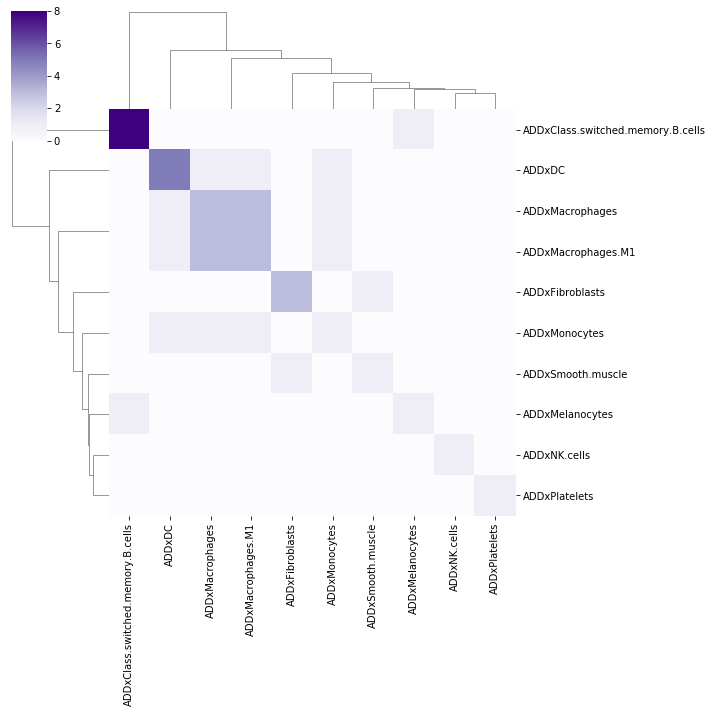

In [108]:
f=plt.figure(figsize=(20,20))
ax=sns.clustermap(df_expand,cmap="Purples")
plt.savefig("../plots/hla.xcell.int.overlap.pdf")

In [110]:
cell_interact_sig

,assoc,fdr,cell
9,6:31243767:G:C_HLA.C,0.074341,ADDxClass.switched.memory.B.cells
35,6:32645906:A:G_HLA.DQB1,0.074341,ADDxClass.switched.memory.B.cells
41,6:32615945:A:T_HLA.DQB1,0.035622,ADDxClass.switched.memory.B.cells
46,6:32200235:G:A_HLA.DQB1,0.069821,ADDxClass.switched.memory.B.cells
54,6:32624128:C:T_HLA.DQB1,0.069821,ADDxClass.switched.memory.B.cells
72,6:32603936:A:G_HLA.DQB1,0.067039,ADDxClass.switched.memory.B.cells
77,6:31243785:G:T_HLA.C,0.069821,ADDxClass.switched.memory.B.cells
80,6:32610059:G:T_HLA.DQA1,0.069821,ADDxClass.switched.memory.B.cells
24,6:32620572:A:G_HLA.DQB1,0.032620,ADDxDC
25,6:32634243:G:A_HLA.DQB1,0.091905,ADDxDC


In [30]:
cov=[]
num=[]

for x in ax.data2d.columns.tolist():
    cov.append(x)
    num.append(len(cell_interact_sig[cell_interact_sig["cell"]==x]))

In [31]:
df_bar=pd.DataFrame({"cov":cov,"num":num})

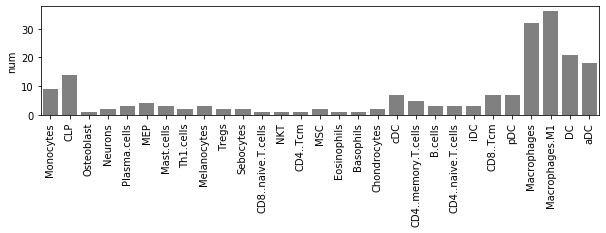

In [32]:
f=plt.figure(figsize=(10,2))
sns.barplot([x.split("ADDx")[1] for x in df_bar["cov"]],df_bar["num"],color="gray")
plt.xticks(rotation=90)
plt.savefig("../plots/tcga.xcell.num.pdf")